## BERT for question/answering

In [7]:
import os

# disable w&b
os.environ["WANDB_DISABLED"] = "true"

In [9]:
from transformers import BertTokenizerFast, BertForQuestionAnswering, pipeline, \
                         DataCollatorWithPadding, TrainingArguments, Trainer, \
                         AutoModelForQuestionAnswering, AutoTokenizer
from datasets import Dataset
import pandas as pd
 
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

In [11]:
bert_tokenizer = BertTokenizerFast.from_pretrained('distilbert-base-cased', return_token_type_ids=True)#bert-large-uncased

qa_bert = BertForQuestionAnswering.from_pretrained('distilbert-base-cased')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing BertForQuestionAnswering: ['distilbert.transformer.layer.1.attention.v_lin.bias', 'distilbert.transformer.layer.1.output_layer_norm.bias', 'distilbert.transformer.layer.3.attention.out_lin.weight', 'distilbert.transformer.layer.4.attention.out_lin.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.5.output_layer_norm.weight', 'distilbert.transformer.layer.3.s

In [12]:
qa_df = pd.read_csv('../../Data/qa.csv')

qa_df.shape

(29989, 5)

In [13]:
qa_df.head()

,question,context,start_positions,end_positions,answer
0,What sare the benifts of the blood brain barrir?,Another approach to brain function is to exami...,56,60,isolated from the bloodstream
1,What is surrounded by cerebrospinal fluid?,Another approach to brain function is to exami...,16,16,brain
2,What does the skull protect?,Another approach to brain function is to exami...,11,11,brain
3,What has been injected into rats to produce pr...,Another approach to brain function is to exami...,153,153,chemicals
4,What can cause issues with how the brain works?,Another approach to brain function is to exami...,93,94,brain damage


In [14]:
qa_df.iloc[0]

question            What sare the benifts of the blood brain barrir?
context            Another approach to brain function is to exami...
start_positions                                                   56
end_positions                                                     60
answer                                 isolated from the bloodstream
Name: 0, dtype: object

In [15]:
# index 56, 57, 58, 59, and 60 including question while encoding
bert_tokenizer.decode(bert_tokenizer.encode(qa_df.iloc[0].question, qa_df.iloc[0].context)[56:61])

'and isolated from the blood'

In [16]:
# only grab 1,000 examples
qa_dataset = Dataset.from_pandas(qa_df.sample(1000, random_state=42))

# Dataset has a built in train test split method
qa_dataset = qa_dataset.train_test_split(test_size=0.2)

In [17]:
qa_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'start_positions', 'end_positions', 'answer', '__index_level_0__'],
        num_rows: 800
    })
    test: Dataset({
        features: ['question', 'context', 'start_positions', 'end_positions', 'answer', '__index_level_0__'],
        num_rows: 200
    })
})

In [18]:
bert_tokenizer('hi', 'there')

{'input_ids': [101, 20844, 102, 1175, 102], 'token_type_ids': [0, 0, 0, 1, 1], 'attention_mask': [1, 1, 1, 1, 1]}

In [20]:
bert_tokenizer.decode([101, 20844, 102, 1175, 102])

'[CLS] hi [SEP] there [SEP]'

In [21]:
# standard preprocessing here with truncation on to truncate longer text
def preprocess(data):
    return bert_tokenizer(data['question'], data['context'], truncation=True)

qa_dataset = qa_dataset.map(preprocess, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
# freeze all but the last 2 encoder layers in BERT to speed up training
#large model olduğu içni fine tuning çook uzun sürebilir
for name, param in qa_bert.bert.named_parameters():
    if 'encoder.layer.22' in name:
        break
    param.requires_grad = False  # disable training in BERT

In [24]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)
data_collator

DataCollatorWithPadding(tokenizer=PreTrainedTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [25]:
qa_dataset['train']

Dataset({
    features: ['question', 'context', 'start_positions', 'end_positions', 'answer', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 800
})

In [21]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='./qa/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./qa/logs',
    save_strategy='epoch',
    logging_steps=10,
    evaluation_strategy='epoch',
    load_best_model_at_end=True,
#     report_to="wandb",  # enable logging to W&B
)

trainer = Trainer(
    model=qa_bert,
    args=training_args,
    train_dataset=qa_dataset['train'],
    eval_dataset=qa_dataset['test'],
    data_collator=data_collator
)

# Get initial metrics
trainer.evaluate()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: question, answer, __index_level_0__, context. If question, answer, __index_level_0__, context are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32


{'eval_loss': 5.790337562561035,
 'eval_runtime': 278.3471,
 'eval_samples_per_second': 0.719,
 'eval_steps_per_second': 0.025}

In [22]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: question, answer, __index_level_0__, context. If question, answer, __index_level_0__, context are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 800
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Epoch,Training Loss,Validation Loss
1,5.126800,4.921113
2,4.707800,4.785754


The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: question, answer, __index_level_0__, context. If question, answer, __index_level_0__, context are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
Saving model checkpoint to ./qa/results/checkpoint-25
Configuration saved in ./qa/results/checkpoint-25/config.json
Model weights saved in ./qa/results/checkpoint-25/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: question, answer, __index_level_0__, context. If question, answer, __index_level_0__, context are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
Saving model check

TrainOutput(global_step=50, training_loss=5.0607952117919925, metrics={'train_runtime': 4314.2306, 'train_samples_per_second': 0.371, 'train_steps_per_second': 0.012, 'total_flos': 1059944898953088.0, 'train_loss': 5.0607952117919925, 'epoch': 2.0})

In [23]:
# Q/A models are very large and take a long time to fine-tune

In [24]:
trainer.save_model()

Saving model checkpoint to ./qa/results
Configuration saved in ./qa/results/config.json
Model weights saved in ./qa/results/pytorch_model.bin


In [3]:
pipe = pipeline("question-answering", './qa/results', tokenizer=bert_tokenizer)

NameError: name 'pipeline' is not defined

In [2]:
pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

NameError: name 'pipe' is not defined

In [27]:
princeton = """In 1675, a Quaker missionary from England, encouraged by New Jersey proprietors John Lord 
              "Berkeley and Sir George Carteret, arrived to establish a settlement in this area near the 
              "Delaware River, which was inhabited by the Lenni-Lenape Indians. The Keith survey of 1685 
              "established the western boundary of Middlesex and Somerset Counties and later, the Township 
              "of Princeton. Today Keith's Line is recognized as Province Line Road. With the laying of the 
              "cornerstone for Nassau Hall in 1754, Princeton began its development as a location for 
              "quality education. Nassau Hall was named for William III, Prince of Orange-Nassau. This simple stone 
              "edifice was one of the largest public buildings in the colonies and became a model for many other 
              "structures in New Jersey and Pennsylvania."""

# quick and dirty fine-tuning doesn't always lead to best results especially for complex tasks like Q/A
pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.0005139763816259801, 'start': 34, 'end': 41, 'answer': 'England'}

# Finetuning made our model better at our specific dataset but loses quality in general Q/A

In [29]:
# From Huggingface: https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad

squad_pipe = pipeline("question-answering", "bert-large-uncased-whole-word-masking-finetuned-squad")

loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loa

In [1]:
squad_pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

NameError: name 'squad_pipe' is not defined

In [31]:
squad_pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.31145334243774414,
 'start': 277,
 'end': 293,
 'answer': 'The Keith survey'}

In [32]:
squad_pipe(f'Who is {PERSON}?', google_html)

{'score': 0.16757884621620178,
 'start': 273,
 'end': 304,
 'answer': 'Founder + CTO - Stealth Startup'}

In [33]:
# visualize logits
large_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

qa_input = large_tokenizer(  # tokenize our example
    "Where is Matt living these days?", "Sinan lives in California but Matt lives in Boston.",
    return_tensors='pt'
)

loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loa

In [34]:
large_qa_bert = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

output = large_qa_bert(**qa_input)  # pass the input through our QA model
output

loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loa

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-5.3843, -6.8294, -7.6400, -6.4639, -6.7897, -6.7944, -8.0679, -8.6584,
         -5.3841, -3.7690, -6.2489, -4.9218, -4.7546, -2.2841, -5.6681,  1.2186,
         -1.7961,  0.2458,  6.9718, -5.3786, -5.3845]],
       grad_fn=<CloneBackward0>), end_logits=tensor([[-1.2085, -6.1980, -6.2445, -6.1047, -6.5146, -6.4224, -5.5075, -6.1881,
         -1.2082, -5.8730, -3.8963, -5.7086, -6.6027, -1.5716, -5.0352, -3.4328,
         -4.6502, -4.0414,  7.1187, -1.2105, -1.2129]],
       grad_fn=<CloneBackward0>), hidden_states=None, attentions=None)

In [35]:
token_labels = large_tokenizer.convert_ids_to_tokens(qa_input['input_ids'].squeeze())

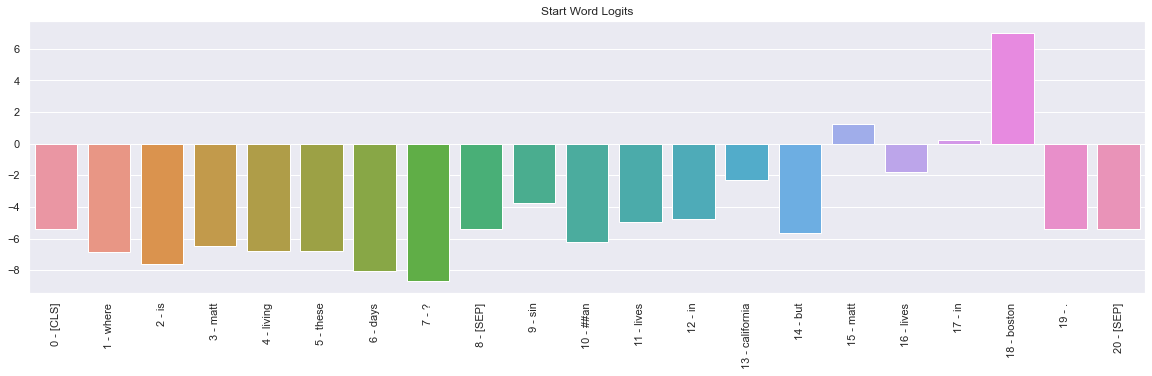

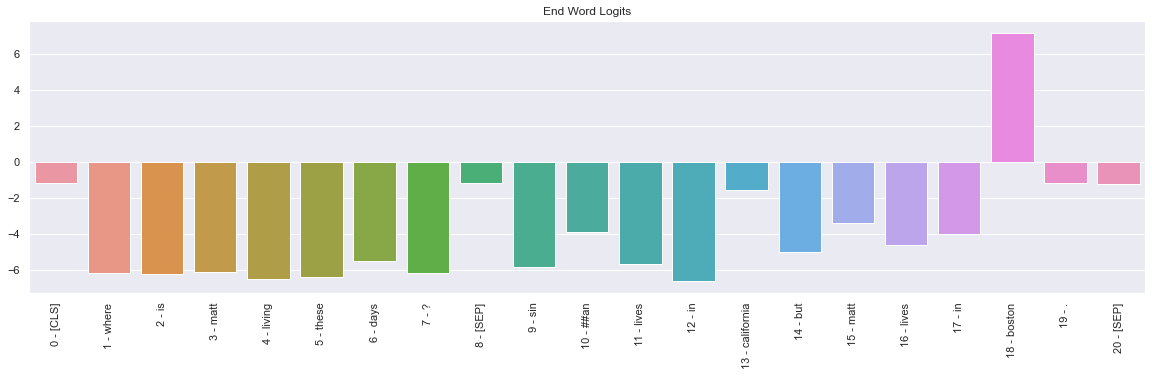

In [36]:
# Plot start and end logits for our fine-tuned model

sns.set(rc={"figure.figsize":(20, 5)}) 

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('Start Word Logits')

plt.show()

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('End Word Logits')

plt.show()